In [812]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

import gurobipy as grb
from gurobipy import GRB

c:\Users\faust\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Input Problem Parameters

## Import du problème

In [813]:
from utils.extract_parameters import extract_parameters

################################
######## TO DO #################
################################

# choose taille among: "small", "medium", "large"
taille = "small"

In [814]:
################################
######## DO NOT CHANGE #########
################################
map_employe_indice, map_job_indice, map_qualif_indice, conge, qualif, d, p, b, besoin = extract_parameters(taille)

In [815]:
print("conge : ",conge)
print("qualif : ",qualif)
print("date livraison : ",d)
print("pénalité : ",p)
print("bénéfice : ",b)
print("besoin : ",besoin)

conge :  [[1, 1, 1, 1, 1], [0, 1, 1, 1, 1], [1, 0, 1, 1, 1]]
qualif :  [[1, 1, 0], [1, 1, 0], [1, 0, 1]]
date livraison :  [3, 3, 4, 3, 5]
pénalité :  [3, 3, 3, 3, 3]
bénéfice :  [20, 15, 15, 20, 10]
besoin :  [[1, 1, 1, 0, 0], [1, 2, 0, 2, 0], [1, 0, 2, 1, 2]]


## Définissons les paramètres

In [816]:
from utils.define_nums import define_nums

nombre_employes, horizon, nombre_qualifs, nombre_projets = define_nums(conge, qualif, d, p, b, besoin)

In [817]:
print("nombre_employes : ",nombre_employes)
print("horizon : ",horizon)
print("nombre_qualifs : ",nombre_qualifs)
print("nombre_projets : ",nombre_projets)

nombre_employes :  3
horizon :  5
nombre_qualifs :  3
nombre_projets :  5


In [818]:
## u_j, le projet j est réalisé
u_shape = nombre_projets

## x_i_j_k_n, l'employé k travaille sur le projet j avec la qualif i
## au jour n
x_shape = [(i,j,k, n) for i in range(nombre_qualifs) for j in range(nombre_projets) for k in range(nombre_employes) for n in range(horizon)]

## t_k_j, l'employé k travaille sur le projet j
t_shape = [(i,j) for i in range(nombre_employes) for j in range(nombre_projets)]

## begin_j, la date de début effective
begin_shape = nombre_projets

## end_j, la date de fin effective = date de livraison du projet j
end_shape = nombre_projets

## delay_j, le nombre de jours de retard par projet j
delay_shape = nombre_projets

## longueur_j, la longueur du projet j
longueur_shape = nombre_projets

## projet_par_employe_k, le nombre de projet par employe
projet_par_employe_shape = nombre_employes

# majorant pour la contrainte de couverture
maj = max([besoin[i][j] for j in range(nombre_projets) for i in range(nombre_qualifs)]) + 1

# si le projet j est travaillé au jour n
job_in_process_shape = [(j, n) for j in range(nombre_projets) for n in range(horizon)]

# Model deployment

## Add the variables

In [819]:
model = grb.Model("Planning")

# L'affectation du planning, la variable clé
x = model.addVars(x_shape, vtype=GRB.BINARY, name="x")

## Les dates de fin des projets
dateFin = model.addVars(end_shape, lb = 0, ub = horizon, name = "dateFin")

## Les dates de début des projets
dateDebut = model.addVars(begin_shape, lb = 0, ub = horizon, name = "dateDebut")

## Le nombre de jours de delai
delay = model.addVars(delay_shape, lb = 0, ub = horizon, name = "delay")

## Les longueurs des projets
longueur = model.addVars(longueur_shape, lb = 0, ub = horizon, name = "longueur")

## Nombre de projet par employé
projet_par_employe = model.addVars(projet_par_employe_shape, lb = 0, ub = nombre_projets, name = "projet_par_employe")

## L'affectation sur un projet d'un employé
affectation = model.addVars(t_shape, vtype = GRB.BINARY, name = "affectation")

## La réalisation ou non d'un projet
u = model.addVars(u_shape, vtype = GRB.BINARY, name="u")

## Verification du projet
job_in_process = model.addVars(job_in_process_shape, vtype = GRB.BINARY, name = "job_in_process")

In [820]:
# Update le modele pour confirmer la création des variables
model.update()


## Add constraints

In [821]:
for i in range(nombre_qualifs):
    for j in range(nombre_projets):
        for k in range(nombre_employes):
            for n in range(horizon):
                ## La qualification du personnel
                model.addConstr( x[i,j,k,n] <= qualif[i][k], name="QualificationPersonnel[{0}{1}{2}{3}]".format(i,j,k,n))
                model.addConstr( x[i,j,k,n] <= (besoin[i][j] >=1), name = "BesoinQualifPersonnel[{0}{1}{2}{3}]".format(i,j,k,n))
                ## Contraintes des congés
                model.addConstr( x[i,j,k,n] <= conge[k][n], name=f"CongesPersonnel[{i}{j}{k}{n}]")
        
        ## Contrainte d'unicité de réalisation d'un projet
        model.addConstr(grb.quicksum(grb.quicksum(x[i,j,k,n] for n in range(horizon)) for k in range(nombre_employes)) == besoin[i][j]*u[j], name=f"UniciteRealisation[{i}{j}]")

        ## Couverture des qualifications
        # model.addConstr( grb.quicksum(grb.quicksum(x[i,j,k,n] for n in range(horizon)) for k in range(nombre_employes)) - besoin[i][j] >= maj*(1-u[j]), name=f"CouvertureQualificationsInf[{i}{j}]") 


## Unicité de l'affectation quotidienne
for k in range(nombre_employes):
    for n in range(horizon):
        model.addConstr(grb.quicksum(grb.quicksum(x[i,j,k,n] for j in range(nombre_projets)) for i in range(nombre_qualifs)) <= 1, name=f"UniciteAffectation[{k}{n}]")

        
for j in range(nombre_projets):
    for n in range(horizon):
        model.addConstrs(((job_in_process[j,n] >= x[i,j,k,n]) for i in range(nombre_qualifs) for k in range(nombre_employes)), name=f"ContrainteJobInProcess[{j}{n}]")
    # start date
    model.addConstrs(((dateDebut[j] <= job_in_process[j,n]*n) for n in range(horizon)), name = f"ContrainteDateDebut[{j}]")

    # end date
    model.addConstrs(((job_in_process[j,n]*n <= dateFin[j]) for n in range(horizon)), name=f"FinProjet[{j}]")

    ## longueur
    model.addConstr(longueur[j] == dateFin[j] - dateDebut[j], name=f"LongueurProjet[{j}]")

    ## delay
    model.addConstr(delay[j] >= dateFin[j] - (d[j] - 1), name=f"DelaiProjet_difference[{j}]")    

## projet_par_employe
for k in range(nombre_employes):
    model.addConstr(projet_par_employe[k] == grb.quicksum( affectation[k,j] for j in range(nombre_projets)), name=f"FinProjet[{j}]")
    
    
## Contrainte de l'affectation à un projet selon les jours de travail
for k in range(nombre_employes):
    for j in range(nombre_projets):
        model.addConstr(affectation[k,j] <= grb.quicksum(grb.quicksum(x[i,j,k,n] for i in range(nombre_qualifs)) for n in range(horizon)), name=f"AffectationProjetQuicksum[{k}{j}]")    

## Fonctions objectif

In [822]:
## bénéfice total
benefice_tot = grb.quicksum( (b[j]*u[j] - delay[j]*p[j]) for j in range(nombre_projets) )

## Lignes pour optimiser le modèles
## sur le bénéfice total seulement

# model.ModelSense = GRB.MAXIMIZE
# model.setObjective(benefice_tot)
# model.ModelSense = GRB.MAXIMIZE

In [823]:
# Lignes pour optimiser le problème suivant
## les trois fonctions objectif voulues

# Nombre de projet maximum par personne
projet_max = model.addVar(lb= 0, ub=nombre_projets, name="projet_max")
model.addConstrs(projet_max>=projet_par_employe[k] for k in range(nombre_employes))

# Compacité des projets
longueur_max = model.addVar(lb = 0, ub=horizon, name="longueur_max")
model.addConstrs(longueur_max>=longueur[j] for j in range(nombre_projets))

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

In [824]:
model.update()

In [825]:
res = pd.DataFrame(columns = ["Benefice", "longueur max", "projets max"])

for l in range(horizon-1, 0 , -1):
    for p in range(nombre_projets-1, 0, -1):
        # contrainte sur la longueur des projets
        model.addConstr(longueur_max<=l)
        # contrainte sur le nombre de projets
        model.addConstr(projet_max<=p)

        model.ModelSense = GRB.MAXIMIZE
        model.setObjective(benefice_tot)
        model.optimize()

        res.loc[len(res)] = [model.objVal, int(longueur_max.x), int(projet_max.x)]
        
        model.reset(1)

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1018 rows, 295 columns and 1976 nonzeros
Model fingerprint: 0x6790b0ab
Variable types: 25 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 966 rows and 190 columns
Presolve time: 0.00s
Presolved: 52 rows, 105 columns, 270 nonzeros
Variable types: 0 continuous, 105 integer (102 binary)
Found heuristic solution: objective 20.0000000

Root relaxation: objective 7.200000e+01, 79 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbe

In [826]:
res

,Benefice,longueur max,projets max
0,65.0,4.0,4.0
1,65.0,4.0,3.0
2,65.0,4.0,2.0
3,65.0,4.0,1.0
4,55.0,3.0,1.0
5,55.0,3.0,1.0
6,55.0,3.0,1.0
7,55.0,3.0,1.0
8,40.0,2.0,1.0
9,40.0,2.0,1.0


# Model optimisation

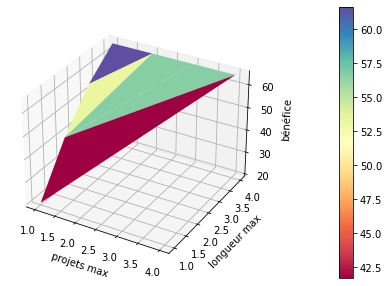

In [827]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(res["projets max"], res["longueur max"])
Z = res["Benefice"]

X = np.array(res["projets max"])
Y = np.array(res["longueur max"])
Z = np.array(res["Benefice"])

# Plot the surface.
surf = ax.plot_trisurf(X, Y, Z, cmap = 'Spectral')

# Add a color bar which maps values to colors.
fig.colorbar(surf, pad=0.2)

ax.set_xlabel('projets max')
ax.set_ylabel('longueur max')
ax.set_zlabel('bénéfice')

fig.set_size_inches(7, 5)

if taille == "small":
    plt.savefig("results/sys_preference/small.png")
elif taille=="medium":
    plt.savefig("results/sys_preference/medium.png")
else:
    plt.savefig("results/sys_preference/large.png")

plt.show()

In [828]:
# Verify model formulation

#nom = "results/"+taille+".lp"
#model.write(nom)

# Run optimization engine

# model.optimize()

In [829]:
## Print the values of all variables
# for v in model.getVars():
#     print(f"{v.VarName} = {v.X}")

# Pour voir quels sont les projets faits
# for j in range(nombre_projets):
#     v = model.getVarByName(f"u[{j}]")
#     if int(v.x) == 1:
#         print(f"la tâche {j} est faite")
#     else:
#         print(f"la tâche {j} n'est pas faite")

In [830]:
model.reset(1)
model.update()

model.addConstr(longueur_max<=4)
# contrainte sur le nombre de projets
model.addConstr(projet_max<=4)

model.ModelSense = GRB.MAXIMIZE
model.setObjective(benefice_tot)
model.optimize()

Discarded solution information including additional information
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[x86])

CPU model: Intel(R) Core(TM) i7-1065G7 CPU @ 1.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1050 rows, 295 columns and 2008 nonzeros
Model fingerprint: 0x43410408
Variable types: 25 continuous, 270 integer (270 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [3e+00, 2e+01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 1036 rows and 260 columns
Presolve time: 0.00s
Presolved: 14 rows, 35 columns, 70 nonzeros
Variable types: 0 continuous, 35 integer (35 binary)
Found heuristic solution: objective 20.0000000

Root relaxation: objective 2.666667e+01, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective 

In [831]:
# Edt des employés et le détail de la réalisation de chaque tâche (de façon ordonnée)
schedules = []
tasks_performances = []
for i in range(nombre_qualifs):
    for j in range(nombre_projets):
        for k in range(nombre_employes):
            for n in range(horizon):
                v = model.getVarByName(f"x[{i},{j},{k},{n}]")
                if int(v.x) == 1:
                    schedules.append((map_employe_indice[k], n+1, map_job_indice[j], map_qualif_indice[i]))
                    tasks_performances.append((map_job_indice[j], map_qualif_indice[i], map_employe_indice[k], n+1))

schedules.sort()

tasks_performances.sort()

# Dates de début et de fin des tâches réalisees 
# (à n'étudier que lorsque longueur_max est mis en objectif, sinon les 
# variables dateDebut et dateFin ne sont pas assez contraintes pour prendre exactement le sens souhaité)

# for j in range(nombre_projets):
#     v = model.getVarByName(f"u[{j}]")
#     v1 = model.getVarByName(f"dateDebut[{j}]")
#     v2 = model.getVarByName(f"dateFin[{j}]")
#     if int(v.x) == 1:
#         print(f"la tâche {j} commence à la date {int(1+v1.x)} et finit à la date {int(1+v2.x)}")

In [832]:
schedules

[('Emma', 1, 'Job1', 'C'),
 ('Olivia', 1, 'Job1', 'A'),
 ('Olivia', 2, 'Job1', 'B')]

In [833]:
# Cette partie n'est pas finie
df = pd.DataFrame(schedules, columns=['Nom', 'Jour', 'Projet', 'Qualification'])

df['Affectation'] = df[['Projet', 'Qualification']].values.tolist()

df = df.pivot(index=['Nom'], 
                    columns=['Jour'],
                    values=['Affectation'])

df.fillna(0, inplace=True)
df

Affectation           
Jour             1          2
Nom                          
Emma     [Job1, C]          0
Olivia   [Job1, A]  [Job1, B]

In [834]:
from utils.show_planning import show_planning

df = pd.DataFrame(schedules, columns=['Nom', 'Jour', 'Projet', 'Qualification'])
show_planning(df)

ModuleNotFoundError: No module named '_tkinter'

In [24]:
## Avec seulement le bénéfice à optimiser
## Commenter lors de la recherche de solutions non dominées

# if taille == "small":
#     df.to_json(r'results/benefice/small_benefice.json')
# elif taille=="medium":
#     df.to_json(r'results/benefice/medium_benefice.json')
# else:
#     df.to_json(r'results/benefice/large_benefice.json')

In [25]:
model.objVal

20.0

In [26]:
####################
#### RESULTS #######
####################


## Bénéfice totale (small) = 65
## Bénéfice totale (medium) = 413
## Bénéfice totale (large) = 817